# MobileNetV2

MobileNet is a type of convolutional neural network designed to be lighter in terms of architecture. MobileNetV2 is only 53 layers deep. 

This notebook will train our MobileNetV2 model.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import random
from random import shuffle 
import collections
import io
import math

import tensorflow as tf
from tensorflow import keras 

In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Data Preparation

In [3]:
FLOWERS_DIR ='dataset/Annotated-FlowerData-30'
# FLOWERS_DIR ='/content/drive/Shareddrives/Visual Information Processing/FlowerData-30'

In [4]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


In [6]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 30))

In [7]:
print(train_generator.class_indices)

{'Artichoke': 0, 'Azalea': 1, 'Bearded Iris': 2, 'Bird of Paradise': 3, 'Bluebell': 4, 'Bromelia': 5, 'Buttecup': 6, 'Camellia': 7, 'Canna Lily': 8, 'Colts_Foot': 9, 'Columbine': 10, 'Cowslip': 11, 'Crocus': 12, 'Daffodil': 13, 'Daisy': 14, 'Dandelion': 15, 'Fritillary': 16, 'LilyValley': 17, 'Mexican Petunia': 18, 'Pansy': 19, 'Peruvian Lily': 20, 'Poinsettia': 21, 'Purple Coneflower': 22, 'Snapdragon': 23, 'Snowdrop': 24, 'Sunflower': 25, 'Sweet William': 26, 'Tigerlily': 27, 'Tulip': 28, 'Windflower': 29}


In [8]:
# saving labels to txt file
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)
    
print('done!')

done!


In [9]:
save_path = 'labels.txt'
label = np.array(open(save_path).read().splitlines())

## Building the Model 

We implemented transfer learning by loading a pretrained MobileNetV2 (weights learned from the public ImageNet database). Several dense layer was added to the end of the model to make it classify our 30 flower classes.

In [10]:
base_model = MobileNetV2(
    input_shape=(H, W, 3), 
    weights='imagenet',
    include_top=False, 
    pooling='avg',
)

# base_model.summary()

In [11]:
base_model.trainable = False

output_class = 30

model = Sequential([
    base_model,
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(30, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                15390     
Total params: 5,159,518
Trainable params: 2,901,534
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('MobileNetV2_checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

Fit model

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n / BATCH_SIZE, 
    validation_data = validation_generator,
    validation_steps = validation_generator.n / BATCH_SIZE,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
30/30 [==============================] - 111s 4s/step - loss: 0.7795 - accuracy: 0.7503 - val_loss: 0.6057 - val_accuracy: 0.8187

Epoch 00001: val_loss improved from inf to 0.60572, saving model to MobileNetV2_checkpoint.h5
Epoch 2/100
30/30 [==============================] - 98s 3s/step - loss: 0.4259 - accuracy: 0.8648 - val_loss: 0.4872 - val_accuracy: 0.8473

Epoch 00002: val_loss improved from 0.60572 to 0.48717, saving model to MobileNetV2_checkpoint.h5
Epoch 3/100
30/30 [==============================] - 98s 3s/step - loss: 0.3117 - accuracy: 0.8895 - val_loss: 0.3666 - val_accuracy: 0.8758

Epoch 00003: val_loss improved from 0.48717 to 0.36665, saving model to MobileNetV2_checkpoint.h5
Epoch 4/100
30/30 [==============================] - 98s 3s/step - loss: 0.2220 - accuracy: 0.9294 - val_loss: 0.5993 - val_accuracy: 0.8391

Epoch 00004: val_loss did not improve from 0.36665
Epoch 5/100
30/30 [==============================] - 97s 3s/step - loss: 0.2307 - accuracy

## Evaluation

In [17]:
def plot_accuracy_loss(history):
    
    ### Plot the accuracy and the loss during the training of the nn.
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', 
             label = "Training Accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', 
             label = "Validation Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', 
             label = "Training Loss")
    plt.plot(history.history['val_loss'], 'ro--', 
             label = "Validation Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

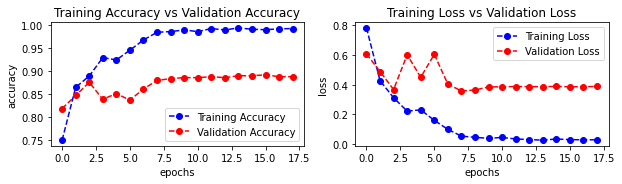

In [18]:
plot_accuracy_loss(history)

## Saving the Model

In [19]:
model.save('MobileNetV2.h5')